In [1]:
import sys, time
import math
import numpy as np
import copy
from pykern import pkcli
from pykern.pkcollections import PKDict
import matplotlib.pyplot as plt

# The rslaser library may not be installed, so a check is required.

# try:
#     import rslaser
# except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
#!{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
#!{sys.executable} -m pip install git+https://github.com/radiasoft/rsmath.git
import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element
from rslaser.optics import wavefront

import scipy.constants as const

import srwlib
from srwlib import srwl

In [2]:
# specify parameters
_LASER_PULSE_SLICE_DEFAULTS = PKDict(
        sigrW=0.0002,
        propLen=15,
        pulseE=0.001,
        poltype=1,
        sampFact=1,
        mx=0,
        my=0
    )
_ENVELOPE_DEFAULTS = PKDict(
    phE=1.55,
    w0=.1,
    a0=.01,
    dw0x=0.0,
    dw0y=0.0,
    z_waist=0,
    dzwx=0.0,
    dzwy=0.0,
    tau_fwhm=0.1 / const.c / math.sqrt(2.),
    z_center=0,
    x_shift = 0.,
    y_shift=0.,
)
_LASER_PULSE_DEFAULTS = PKDict(
        **_ENVELOPE_DEFAULTS,
        nslice=10,
        chirp=0,
        d_to_w=0,
        sigma_cutoff=3.,
        slice_params=_LASER_PULSE_SLICE_DEFAULTS,
)

# Override some of the default parameters
# First, instantiate the default parameters:
params = _LASER_PULSE_DEFAULTS.copy()

lambda0 = 8.e-7                     # wavelength [m]
phE = const.h * const.c / lambda0   # photon energy [J]
phE_ev = phE / const.e              # photon energy [eV]
print(' photon energy = {0:4.2E} [J]'.format(phE) + ' = {0:4.2f} [eV]'.format(phE_ev))

print(' params.tau_fwhm = {0:4.2E} [s]'.format(params.tau_fwhm))
tau_fwhm = 0.3e-13                  # FWHM pulse length [s]
params.tau_fwhm = tau_fwhm

# params.d_to_w = 0.0     #  [m] distance from the initial pulse location to the loc-n of the beam waist, > 0 if converging 
params.d_to_w = 0.011     #  [m] distance from the initial pulse location to the loc-n of the beam waist, > 0 if converging 

# Instantiate the laser pulse
thisPulse = pulse.LaserPulse(params)
thisPulseCopy = copy.deepcopy(thisPulse)

 photon energy = 2.48E-19 [J] = 1.55 [eV]
 params.tau_fwhm = 2.36E-10 [s]


In [3]:
#First implement without a class

_distance_from_pulse_center = .2 #WFS is .2 m from pulse center

nslice = thisPulse.nslice


"""
tau_fwhm = thisPulse.tau_fwhm
sig_s = 2.355 * const.c * tau_fwhm
numsig = thisPulse.numsig #Number of sigma values to track. Total range is 2*numsig*sig_s
"""
sig_s = thisPulse.sig_s
#sig_s = 0.01
sigma_cutoff = thisPulse.sigma_cutoff
#sigma_cutoff = 3.0

wflist = []

for slice_index in np.arange(nslice):
    thisSlice = thisPulse.slice[slice_index] 
    #Now compute position of slice
    ds = 2*sigma_cutoff*sig_s/(nslice)
    slice_pos = -sigma_cutoff*sig_s+slice_index*ds
    print("position of slice /m is ",slice_pos)
   
    sd = slice_pos + _distance_from_pulse_center #distance to propagate
    print("distance from slice to wavefront sensor /m is ",sd)
    #now create an SRW optical container with a drift of length pd
    optDrift=srwlib.SRWLOptD(sd)
    propagParDrift = [0, 0, 1., 0, 0, 1, 1, 1, 1, 0, 0, 0]
    optBLW = srwlib.SRWLOptC([optDrift],[propagParDrift])
    srwlib.srwl.PropagElecField(thisSlice.wfr, optBLW)
        
    wflist.append(thisSlice.wfr)
    
#Now add wavefronts together
wfr = copy.deepcopy(wflist[0])
for slice_index in np.arange(nslice-1):
    wfr.addE(wflist[slice_index + 1])
    

position of slice /m is  -1.1457036611464969e-05
distance from slice to wavefront sensor /m is  0.19998854296338855
position of slice /m is  -9.165629289171975e-06
distance from slice to wavefront sensor /m is  0.19999083437071083
position of slice /m is  -6.874221966878982e-06
distance from slice to wavefront sensor /m is  0.19999312577803313
position of slice /m is  -4.582814644585988e-06
distance from slice to wavefront sensor /m is  0.19999541718535543
position of slice /m is  -2.2914073222929945e-06
distance from slice to wavefront sensor /m is  0.1999977085926777
position of slice /m is  -1.6940658945086007e-21
distance from slice to wavefront sensor /m is  0.2
position of slice /m is  2.291407322292993e-06
distance from slice to wavefront sensor /m is  0.2000022914073223
position of slice /m is  4.582814644585987e-06
distance from slice to wavefront sensor /m is  0.2000045828146446
position of slice /m is  6.87422196687898e-06
distance from slice to wavefront sensor /m is  0.200

In [7]:
# Plot the intensity of the resulting added wavefront at the wavefront sensor
arPhasewfs = srwlib.array('d', [0]*wfr.mesh.nx*wfr.mesh.ny) #"flat" array to take 2D phase data
arIinit = srwlib.array('f', [0]*wfr.mesh.nx*wfr.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr, 0, 0, 3, wfr.mesh.eStart, 0, 0) #extracts intensity
srwl.CalcIntFromElecField(arPhasewfs, wfrout, 6, 4, 3, wfrout.mesh.eStart, 0, 0) #extracts phase

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr.mesh.nx, wfr.mesh.ny), order='C')
arPhase2D = np.array(arPhase).reshape((wfr.mesh.nx, wfr.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr.mesh.xStart,wfr.mesh.xFin,wfr.mesh.nx)
yvalsf02=np.linspace(wfr.mesh.yStart,wfr.mesh.yFin,wfr.mesh.ny)


NameError: name 'arPhasewfs' is not defined

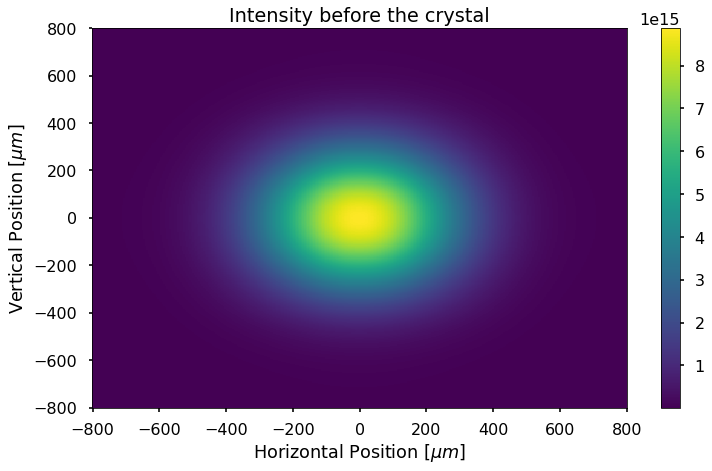

In [5]:
# plot the computed intensity

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Intensity']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('Intensity before the crystal')

NameError: name 'arPhase2D' is not defined

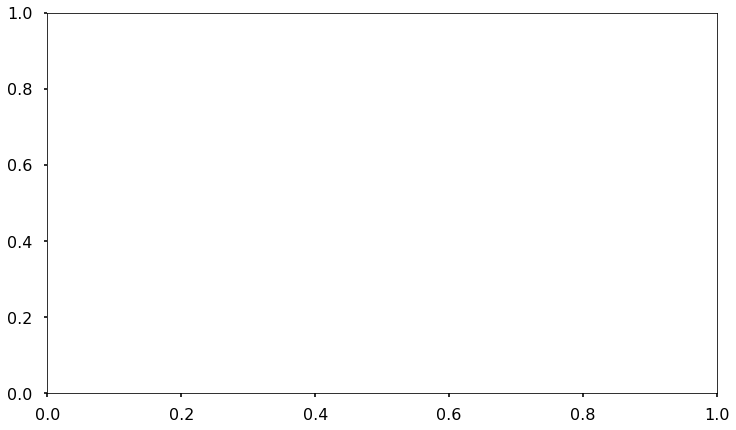

In [6]:
# plot the phase

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arPhase2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Phase']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('wavefront sensor phase')

In [ ]:
#Now test wavefront sensor using class
from rslaser.optics.wavefront import WavefrontSensor

In [ ]:
_distance_from_pulse_center = .2 #WFS is .2 m from pulse center
wfs = WavefrontSensor('thisPulseCopy', _distance_from_pulse_center)
wfrout = wfs.propagate(thisPulseCopy)

In [ ]:
# Extract intensity and phase to plot
arPhasewfs = srwlib.array('d', [0]*wfrout.mesh.nx*wfrout.mesh.ny) #"flat" array to take 2D phase data
arIinitwfs = srwlib.array('f', [0]*wfrout.mesh.nx*wfrout.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arPhasewfs, wfrout, 6, 4, 3, wfrout.mesh.eStart, 0, 0) #extracts phase
srwl.CalcIntFromElecField(arIinitwfs, wfrout, 0, 0, 3, wfrout.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arPhase2Dwfs = np.array(arPhasewfs).reshape((wfrout.mesh.nx, wfrout.mesh.ny), order='C')
arIinit2Dwfs = np.array(arIinitwfs).reshape((wfrout.mesh.nx, wfrout.mesh.ny), order='C')
wfrsizei=np.size(arIinitwfs)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2Dwfs))
xvalsf02wfs=np.linspace(wfrout.mesh.xStart,wfrout.mesh.xFin,wfrout.mesh.nx)
yvalsf02wfs=np.linspace(wfrout.mesh.yStart,wfrout.mesh.yFin,wfrout.mesh.ny)


In [ ]:
# plot the computed intensity

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02wfs,1e6), np.multiply(yvalsf02wfs,1e6), arIinit2Dwfs, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Intensity']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('Intensity at wavefront sensor')

In [ ]:
# plot the phase

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arPhase2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Phase']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('wavefront sensor phase')

In [ ]:
#Compare to phase plot above
# plot the phase

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()

    # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
    plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arPhase2D, cmap=plt.cm.viridis,shading='auto')
    plt.colorbar()
    #['Horizontal Position [mm]', , 'Phase']
    ax.set_ylabel(r'Vertical Position [$\mu m$]')
    ax.set_xlabel(r'Horizontal Position [$\mu m$]')
    ax.set_title('wavefront sensor phase')